# Explainable AI
This notebook has been a working tool to visualise different layers of the supervised models used to segment Atg9 spots in fluorescent microscopy images. The functionality includes plotting single feature maps, saliency maps (total feedback or on selected masks), and GradCAM.

In [2]:
import torch
from torch import nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from IPython import embed
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from make_dataset import SpotDataset, SpotDatasetNoSpots
from model_sweep import SpotModel
#from functions import visualize_predictions
from segmentation_tools import pixel_level_metrics, visualize_predictions
import torch.nn.functional as F
from torchvision import models
from torch.autograd import Function


### Functions to visualise feature maps and calculate saliency maps and GradCAM with different models and inputs. 

In [5]:
def visualize_feature_maps(model, input_image, layer_name):
    model.eval()  # Set model to evaluation mode
    activations = {}
    
    def hook_fn(module, input, output):
        activations[layer_name] = output
    
    layer = dict(model.named_modules())[layer_name]
    layer.register_forward_hook(hook_fn)
    
    with torch.no_grad():
        _ = model(input_image)
    
    activation = activations[layer_name]
    num_features = activation.shape[1]
    
    fig, axes = plt.subplots(1, min(num_features, 8), figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        ax.imshow(activation[0, i].cpu().numpy(), cmap='viridis')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


def compute_segmentation_saliency(model, input_image, ind, gt_mask=None):
    model.eval()
    input_image.requires_grad = True
    image_plot = input_image.cpu().detach().numpy()
    
    # Forward pass
    output = model(input_image)
    plot_output = output.cpu().detach().numpy()
    plt.imshow(plot_output[0][0], cmap='gray')

    # Focus on the specific mask; assuming gt_mask is a binary mask with the same spatial dimensions
    # Create a binary mask from the ground truth mask
    if gt_mask is not None:
        # gt_mask = gt_mask.unsqueeze(0).unsqueeze(0)
        gt_mask = gt_mask.cpu().detach().numpy()
        # Convert mask to uint8
        gt_mask = gt_mask.astype(np.uint8)*255
        # Find contours and draw masks
        num_labels, labels_im = cv2.connectedComponents(gt_mask[0,0])
        
        # Now, num_labels is the number of connected components, and labels_im is the labeled mask
        item_index = 14  # The label of the item you want (remember, labels start from 0)
        
        # Use shape of labels_im for selected_mask
        selected_mask = np.zeros_like(labels_im)  # Shape (256, 256)
        
        # Fill the selected mask where the labels match item_index
        selected_mask[labels_im == item_index] = 1

        fig = plt.imshow(image_plot[0][1], cmap='gray', vmax = 400)
        plt.savefig(f'../plots/original_{ind}.png')
        # plt.clf()

        contours, _ = cv2.findContours(selected_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    
        for contour in contours:
            # Reshape the contour to 2D for plotting
            contour = contour.squeeze()
            if len(contour.shape) == 2:  # Avoid empty contours
                contour =  np.vstack([contour, contour[0]])
                plt.plot(contour[:, 0], contour[:, 1], c='g', linewidth=3)  # Green contour
        plt.savefig(f'../plots/contour_{ind}.png')

        # Ensure gt_mask has correct dimensions (1, 1, H, W)
        selected_mask_tensor = torch.tensor(selected_mask).to('cuda')
    
        # Compute the loss corresponding to the pixels in the specific mask
        loss = (output * selected_mask_tensor).mean()  # Mean activation over pixels in the ground truth mask
    

    else:
        loss = output.mean()
    
    # Backward pass
    model.zero_grad()
    loss.backward()
    
    # Get saliency map from input image gradients
    saliency_map = input_image.grad.data.abs().squeeze().cpu().numpy()
    vmax = saliency_map.max()/4
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        ax.axis('off')    

    axes[0][0].imshow(saliency_map[0], cmap='jet', vmax=vmax)
    axes[0][1].imshow(saliency_map[1], cmap='jet', vmax=vmax)
    axes[0][2].imshow(saliency_map[2], cmap='jet', vmax=vmax)

    axes[1][0].imshow(image_plot[0][0], cmap='gray')#, vmax = 200)
    axes[1][1].imshow(image_plot[0][1], cmap='gray', vmax = 800)
    if gt_mask is not None:
        for contour in contours:
                # Reshape the contour to 2D for plotting
            contour = contour.squeeze()
            if len(contour.shape) == 2:  # Avoid empty contours
                contour =  np.vstack([contour, contour[0]])
                axes[0][1].plot(contour[:, 0], contour[:, 1], c='r', linewidth=3)
                axes[1][1].plot(contour[:, 0], contour[:, 1], c='r', linewidth=3)
                axes[2][1].plot(contour[:, 0], contour[:, 1], c='r', linewidth=3)
    axes[1][2].imshow(image_plot[0][2], cmap='gray', vmax = 400)

    axes[2][0].imshow(image_plot[0][0], cmap='gray' )#, vmax = 200)
    axes[2][0].imshow(saliency_map[0], cmap='jet',  alpha=0.35 , vmax=vmax)
    axes[2][1].imshow(image_plot[0][1], cmap='gray', vmax = 800)
    axes[2][1].imshow(saliency_map[1], cmap='jet', alpha=0.35, vmax=vmax)
    axes[2][2].imshow(image_plot[0][2], cmap='gray', vmax = 400)
    axes[2][2].imshow(saliency_map[2], cmap='jet', alpha=0.35, vmax=vmax)

    axes[0][0].set_title('GFP', fontsize=14)
    axes[0][1].set_title('mCherry', fontsize=14)
    axes[0][2].set_title('Dapi', fontsize=14)

    # Remove ticks
    axes[0, 0].set_xticks([])  # Remove x ticks
    axes[0, 0].set_yticks([])  # Remove y ticks
    
    # Remove ticks
    axes[1, 0].set_xticks([])  # Remove x ticks
    axes[1, 0].set_yticks([])  # Remove y ticks
    
    # Remove ticks
    axes[2, 0].set_xticks([])  # Remove x ticks
    axes[2, 0].set_yticks([])  # Remove y ticks
    axes[0][0].axis('on')
    axes[1][0].axis('on')
    axes[2][0].axis('on')
    axes[0][0].set_ylabel('Saliency map', fontsize=14)
    axes[1][0].set_ylabel('Original image', fontsize=14)
    axes[2][0].set_ylabel('Overlay', fontsize=14)

    plt.axis('off')
    # plt.title('Saliency Map for Object Segmentation')
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'../plots/saliency_maps_{ind}.png')



def saliency_no_spot_channel(model, input_image, ind):
    model.eval()
    input_image.requires_grad = True
    
    # Forward pass
    output = model(input_image)
    plot_output = output.cpu().detach().numpy()
    plot_input = input_image.cpu().detach().numpy()

    print(plot_input.shape)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(plot_input[0][0], cmap='gray')
    ax[1].imshow(plot_input[0][2], cmap='gray')
    ax[2].imshow(plot_output[0][0], cmap='gray')

    ax[0].set_title('Channel 0')  
    ax[1].set_title('Channel 2')
    ax[2].set_title('Output probabilities')
    # Consider mean over all mask pixels as a collective response
    loss = output.mean()
    
    # Backward pass
    model.zero_grad()
    loss.backward()
    
    # Get saliency map from input image gradients
    saliency_map = input_image.grad.data.abs().squeeze().cpu().numpy()
    vmax = saliency_map.max()/4
    
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))
    for i, ax in enumerate(axes.flat):
        ax.axis('off')
    # Plot the saliency map
    # plt.figure(figsize=(10, 10))
    image_plot = input_image.cpu().detach().numpy()

    axes[0][0].imshow(saliency_map[0], cmap='jet', vmax=vmax)
    axes[0][1].imshow(saliency_map[2], cmap='jet', vmax=vmax)
    
    axes[1][0].imshow(image_plot[0][0], cmap='gray')#, vmax = 400)
    axes[1][1].imshow(image_plot[0][2], cmap='gray', vmax = 400)
    
    axes[2][0].imshow(image_plot[0][0], cmap='gray', )
    axes[2][0].imshow(saliency_map[0], cmap='jet',  alpha=0.5, vmax=vmax )
    axes[2][1].imshow(image_plot[0][2], cmap='gray', vmax = 400)
    axes[2][1].imshow(saliency_map[2], cmap='jet', alpha=0.5, vmax=vmax)

    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'../plots/saliency_maps_no_spots_{ind}.png')

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        target_module = dict(self.model.named_modules())[self.target_layer]
        # print(target_module)
        target_module.register_forward_hook(forward_hook)
        target_module.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, class_index, ind):
        # Forward pass and backward pass
        self.model.eval()
        output = self.model(input_image)
        
        # Backward for target class
        self.model.zero_grad()
        # class_loss = output[:, class_index].mean()
        loss = output.mean()
        # class_loss.backward()
        loss.backward()
        
        # Get weighted activations
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
    
        
        # Compute CAM
        activations = self.activations.detach()
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
        
        cam = torch.mean(activations, dim=1).squeeze()
        cam = torch.maximum(cam, torch.tensor(0))
        cam_resized = cv2.resize(cam.cpu().numpy(), (input_image.size(-1), input_image.size(-2)))
        
        # Normalize
        if cam_resized.max() != 0:
            cam_resized -= cam_resized.min()
            cam_resized /= cam_resized.max()

        plot_image = input_image.cpu().detach().numpy()
        plt.imshow(plot_image[0][1], cmap='gray')
        plt.imshow(cam_resized, cmap='jet', alpha = 0.5)
        plt.axis('off')
        plt.title('Grad-CAM')
        # plt.show()

        plt.savefig(f'../plots/grad_cam_{ind}.png')
        return cam_resized


## Saliency maps of selected pixels from GT masks

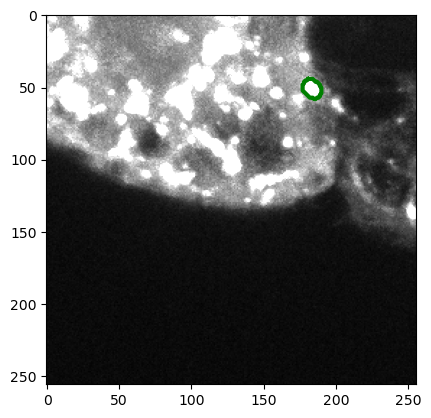

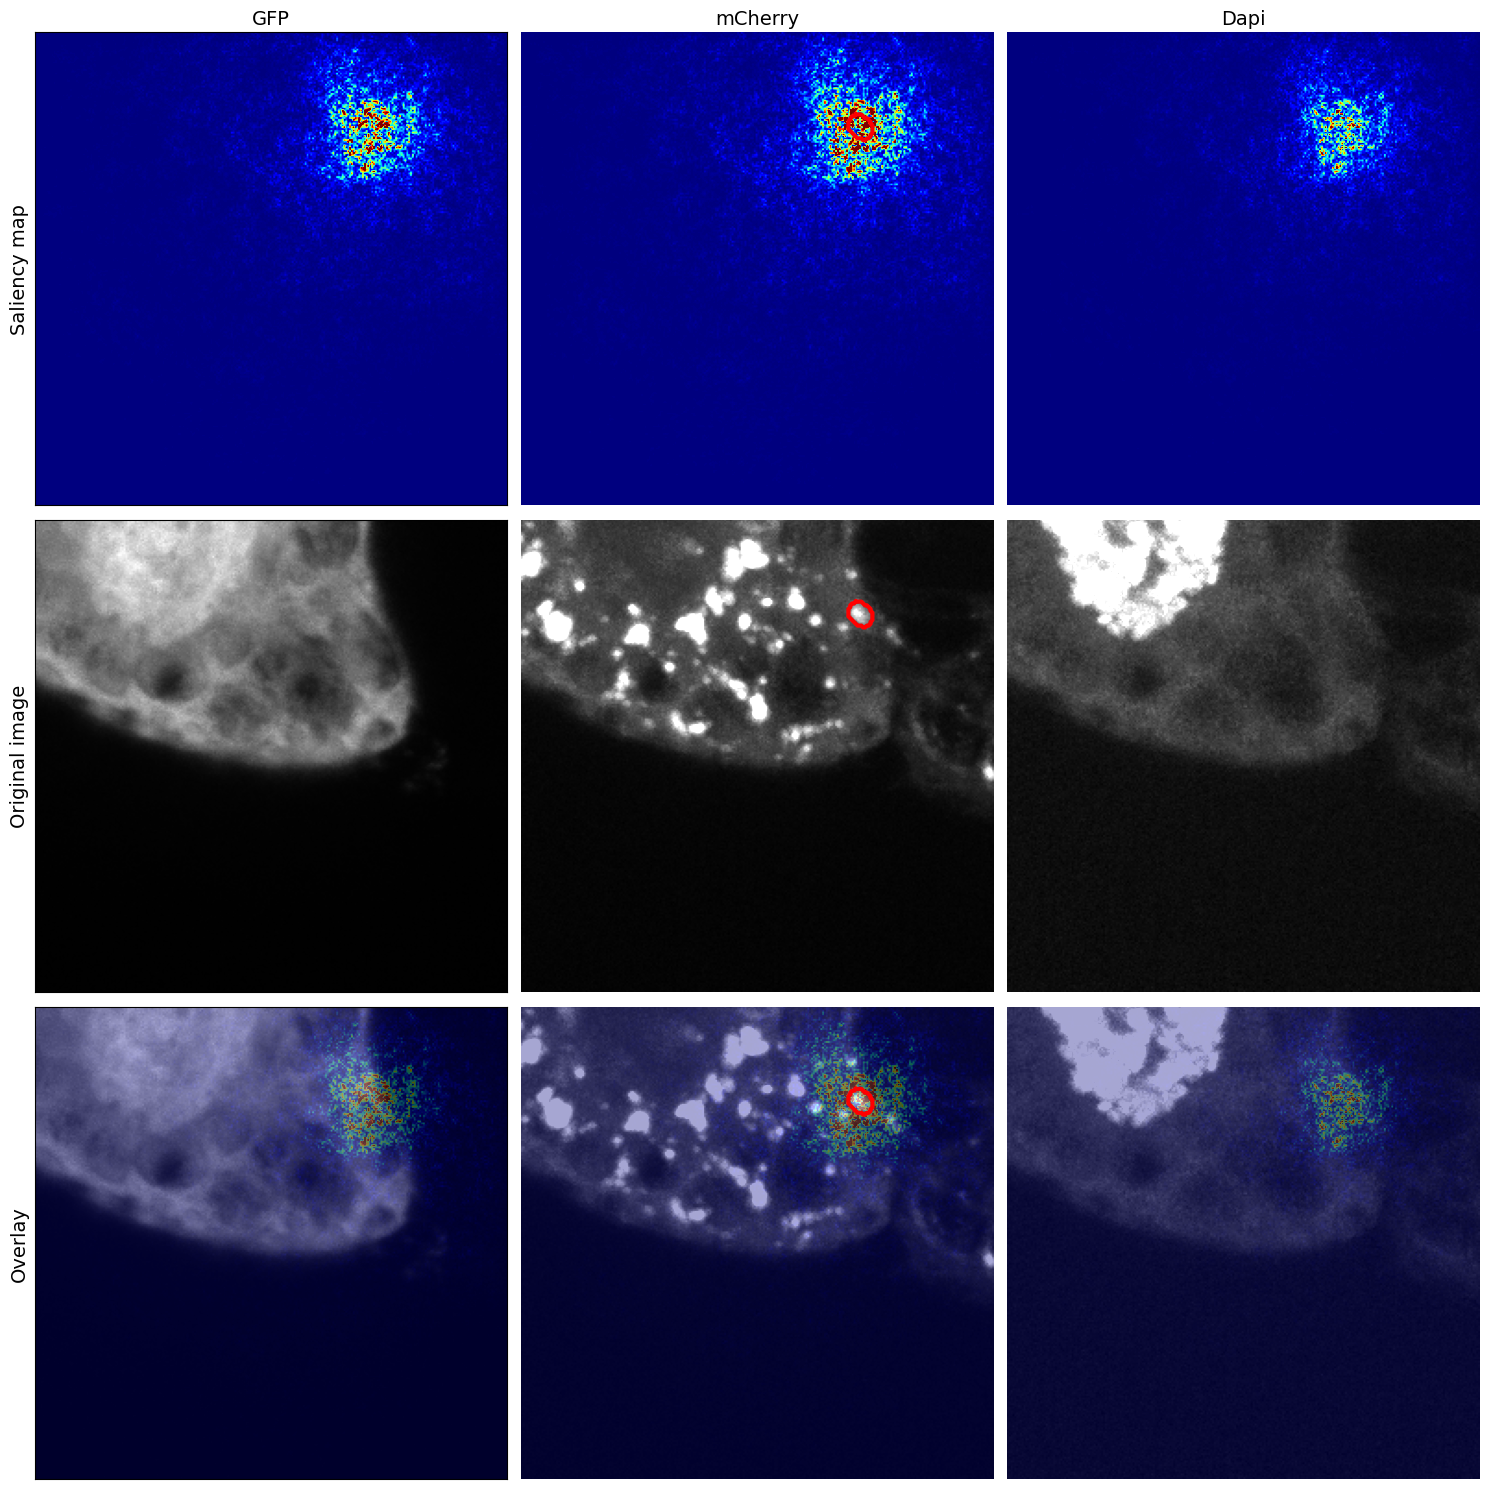

In [4]:
# Choose architecture
architecture ='Unetplusplus' #'Segformer' #'DeepLabV3plus' 
encoder = "resnet34"
batch_size = 1


# Create test dataset and dataloader
test_dataset = SpotDataset(
    image_dir='../../../data/patch_256/test/images',
    mask_dir='../../../data/patch_256/test/masks',
)

test_no_spots = SpotDatasetNoSpots(
    image_dir='../../../data/patch_256/test/images',
    mask_dir='../../../data/patch_256/test/masks',
)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
no_spots_dataloader = DataLoader(test_no_spots, batch_size=batch_size, shuffle=False, num_workers=4)
# Test finetuned model
preprocess_input = get_preprocessing_fn(encoder, pretrained='imagenet')
best_model_path = f"lightning_logs/{architecture}/checkpoints/epoch=20-step=1071.ckpt"
# best_model_path = f"lightning_logs/{architecture}_channel0/checkpoints/epoch=16-step=867.ckpt"
# best_model_path = f"lightning_logs/Unetplusplus_no_spots/checkpoints/epoch=35-step=936.ckpt"
model = SpotModel.load_from_checkpoint(
    best_model_path,
    arch=architecture,
    encoder_name=encoder,
    in_channels=3,
    out_classes=1
)


model = model.to('cuda')
model.eval()

img_indx = [180, 85]

for i, data in enumerate(test_dataloader):
    if i == 180:
        img_id = data['img_id']
        image = data['image'].to('cuda')
        image = image.type(torch.float32)
        gt_mask = data['mask'].to('cuda')

        compute_segmentation_saliency(model.model, image, i, gt_mask=gt_mask)


    else:
        continue

## Visualisation of different layers in the U-Net++, DeeplabV3+ or Segformer models

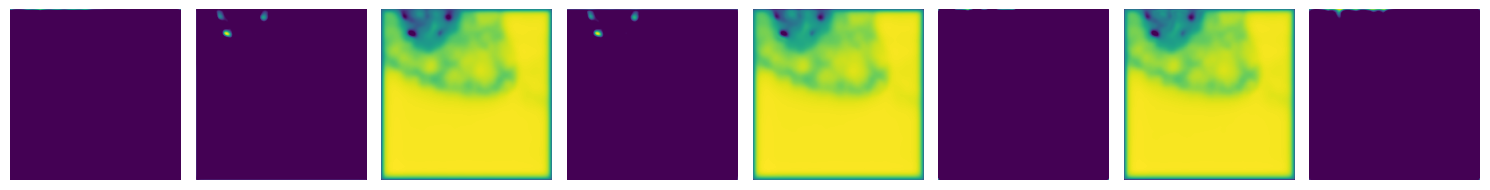

/global/D1/homes/frieda/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


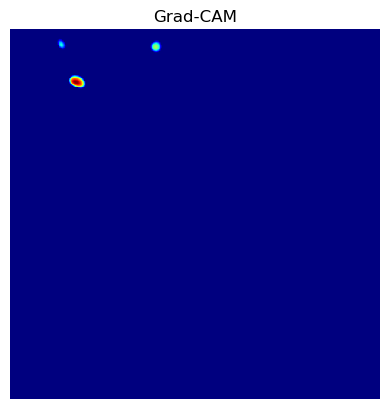

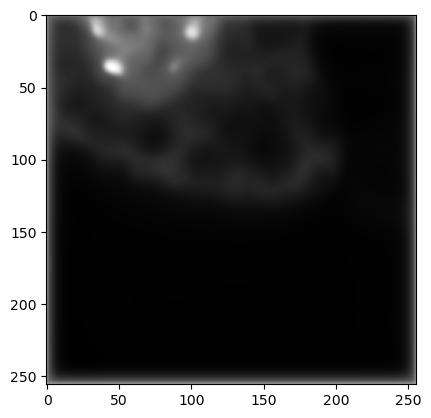

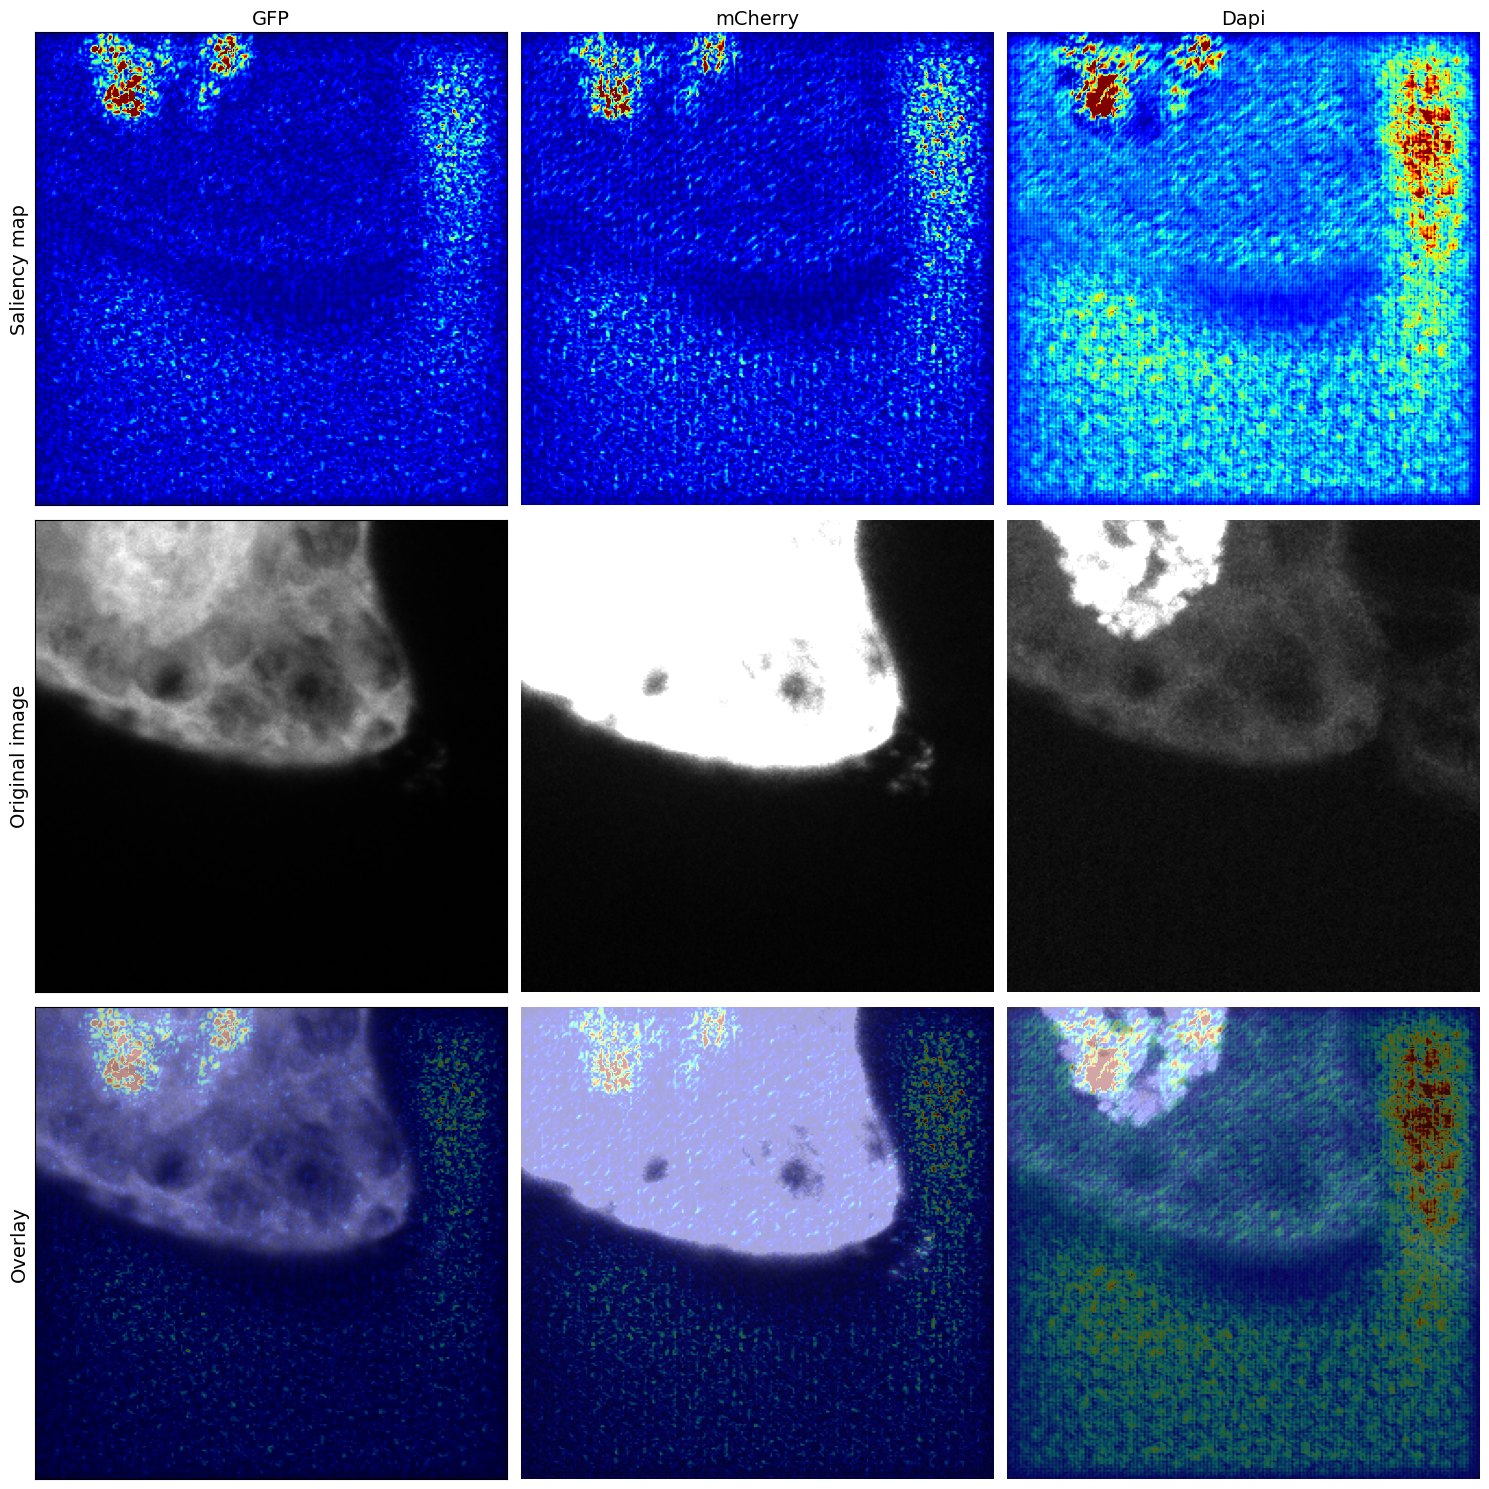

In [7]:
# Choose architecture
architecture = 'Unetplusplus' #'DeepLabV3plus' #'Segformer'
encoder = "resnet34"
batch_size = 1


# Create test dataset and dataloader
test_dataset = SpotDataset(
    image_dir='../../../data/patch_256/test/images',
    mask_dir='../../../data/patch_256/test/masks',
    transform=None,
)

test_no_spots = SpotDatasetNoSpots(
    image_dir='../../../data/patch_256/test/images',
    mask_dir='../../../data/patch_256/test/masks',
    transform=None,
)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
no_spots_dataloader = DataLoader(test_no_spots, batch_size=batch_size, shuffle=False, num_workers=4)
# Test finetuned model
preprocess_input = get_preprocessing_fn(encoder, pretrained='imagenet')
# best_model_path = f"lightning_logs/{architecture}_channel2/checkpoints/epoch=64-step=3315.ckpt"
# best_model_path = f"lightning_logs/{architecture}/checkpoints/epoch=20-step=546.ckpt"
best_model_path = f"lightning_logs/Unetplusplus_no_spots/checkpoints/epoch=35-step=936.ckpt"
model = SpotModel.load_from_checkpoint(
    best_model_path,
    arch=architecture,
    encoder_name=encoder,
    in_channels=3,
    out_classes=1
)


model = model.to('cuda')
model.eval()

img_indx = [180, 85]

for i, data in enumerate(no_spots_dataloader):
    if i == 180:
        img_id = data['img_id']
        image = data['image'].to('cuda')
        image = image.type(torch.float32)
        visualize_feature_maps(model.model, image, 'decoder.blocks.x_0_4.attention2')

        # Example usage
        fig1=plt.figure()
        grad_cam = GradCAM(model.model, target_layer='decoder.blocks.x_0_4.attention2')
        cam = grad_cam.generate_cam(image, class_index=0, ind=i)
        plt.imshow(cam, cmap='jet')
        plt.axis('off')
        plt.title('Grad-CAM')
        plt.show()

        compute_segmentation_saliency(model.model, image, i)

    else:
        continue

##  Visualisation of different layers in the U-Net++, DeeplabV3+ or Segformer models

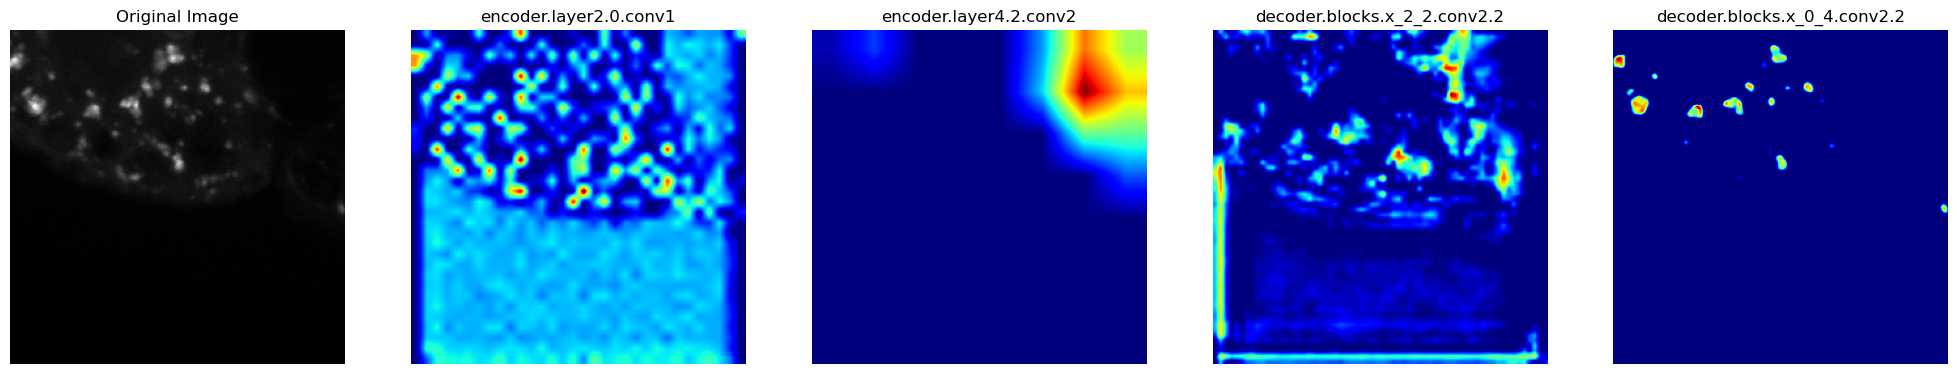

In [19]:
# Choose architecture
architecture = 'Unetplusplus' #'DeepLabV3plus' #'Segformer'
encoder = "resnet34"
batch_size = 1


# Create test dataset and dataloader
test_dataset = SpotDataset(
    image_dir='../../../data/patch_256/test/images',
    mask_dir='../../../data/patch_256/test/masks',
    transform=None,
)

test_no_spots = SpotDatasetNoSpots(
    image_dir='../../../data/patch_256/test/images',
    mask_dir='../../../data/patch_256/test/masks',
    transform=None,
)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
no_spots_dataloader = DataLoader(test_no_spots, batch_size=batch_size, shuffle=False, num_workers=4)
# Test finetuned model
preprocess_input = get_preprocessing_fn(encoder, pretrained='imagenet')
best_model_path = f"lightning_logs/{architecture}/checkpoints/epoch=20-step=1071.ckpt"
# best_model_path = f"lightning_logs/{architecture}/checkpoints/epoch=20-step=546.ckpt"
# best_model_path = f"lightning_logs/Unetplusplus_no_spots/checkpoints/epoch=35-step=936.ckpt"
model = SpotModel.load_from_checkpoint(
    best_model_path,
    arch=architecture,
    encoder_name=encoder,
    in_channels=3,
    out_classes=1
)


model = model.to('cuda')
model.eval()

img_indx = [180, 85]

for i, data in enumerate(test_dataloader):
    if i == 180:
        img_id = data['img_id']
        image = data['image'].to('cuda')

        # logits = model(image) 
        # prob_mask = logits.sigmoid()
        # pred_mask = (prob_mask > 0.5).float()
        # pred_mask = pred_mask.cpu().detach().numpy()
        
        image = image.type(torch.float32)
        # visualize_feature_maps(model.model, image, 'decoder.blocks.x_0_4.attention2')

        

        # Example usage
        fig, ax = plt.subplots(1, 5, figsize=(25, 5))
        
        # ax.imshow(activation[0, i].cpu().numpy(), cmap='viridis')
        # ax.axis('off')

        target1 = 'encoder.layer2.0.conv1'
        grad_cam = GradCAM(model.model, target_layer=target1)
        cam1 = grad_cam.generate_cam(image, class_index=0, ind=i)

        # target2='encoder.layer3.2.conv2'
        target2='encoder.layer4.2.conv2'
        grad_cam = GradCAM(model.model, target_layer=target2)
        cam2 = grad_cam.generate_cam(image, class_index=0, ind=i)

        target3 = 'decoder.blocks.x_2_2.conv2.2'
        grad_cam = GradCAM(model.model, target_layer=target3)
        cam3 = grad_cam.generate_cam(image, class_index=0, ind=i)

        # target3='decoder.blocks.x_0_4.attention2'
        target4='decoder.blocks.x_0_4.conv2.2'
        grad_cam = GradCAM(model.model, target_layer=target4)
        cam4 = grad_cam.generate_cam(image, class_index=0, ind=i)

        ax[0].imshow(data['image'][0][1], cmap='gray')
        ax[0].axis('off')
        ax[0].set_title('Original Image')
        
        ax[1].imshow(cam1, cmap='jet')
        ax[1].axis('off')
        ax[1].set_title(target1)

        ax[2].imshow(cam2, cmap='jet')
        ax[2].axis('off')
        ax[2].set_title(target2)

        ax[3].imshow(cam3, cmap='jet')
        ax[3].axis('off')
        ax[3].set_title(target3)

        ax[4].imshow(cam4, cmap='jet')
        ax[4].axis('off')
        ax[4].set_title(target4)




        
        plt.savefig('../plots/grad_cam_levels.png', bbox_inches='tight', pad_inches=0)

        # compute_segmentation_saliency(model.model, image, i)

    else:
        continue

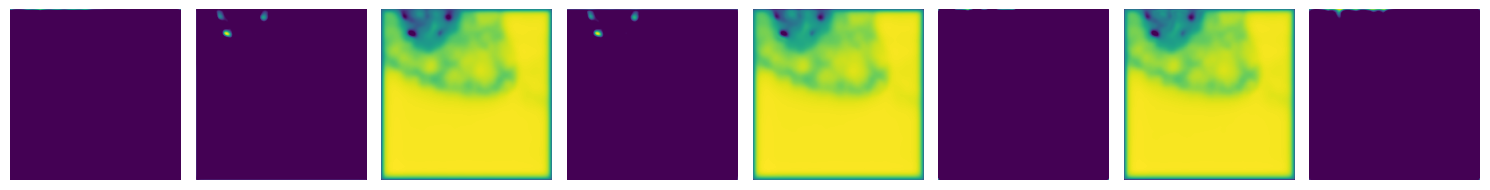

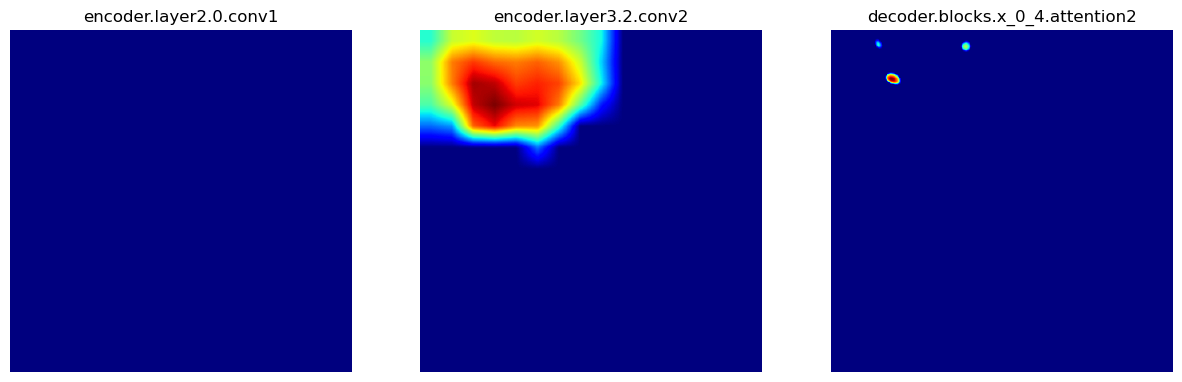

(1, 3, 256, 256)


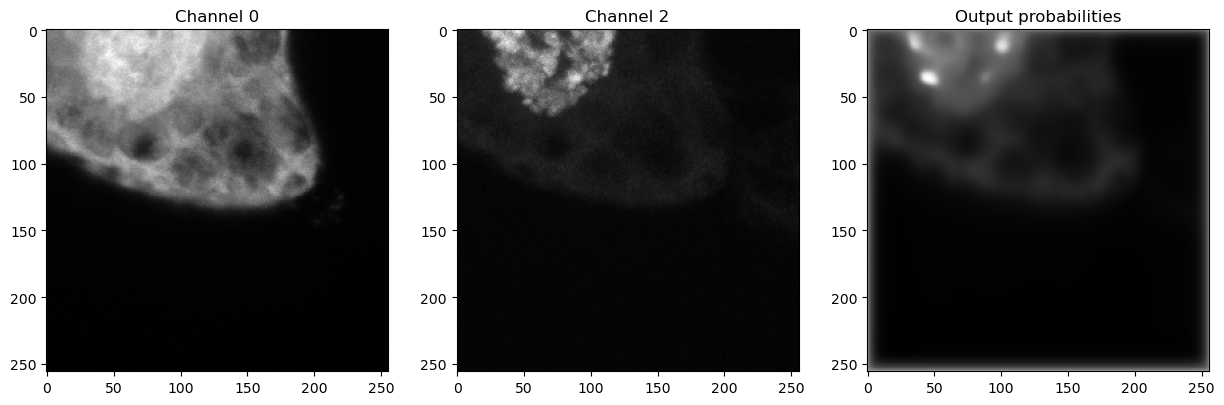

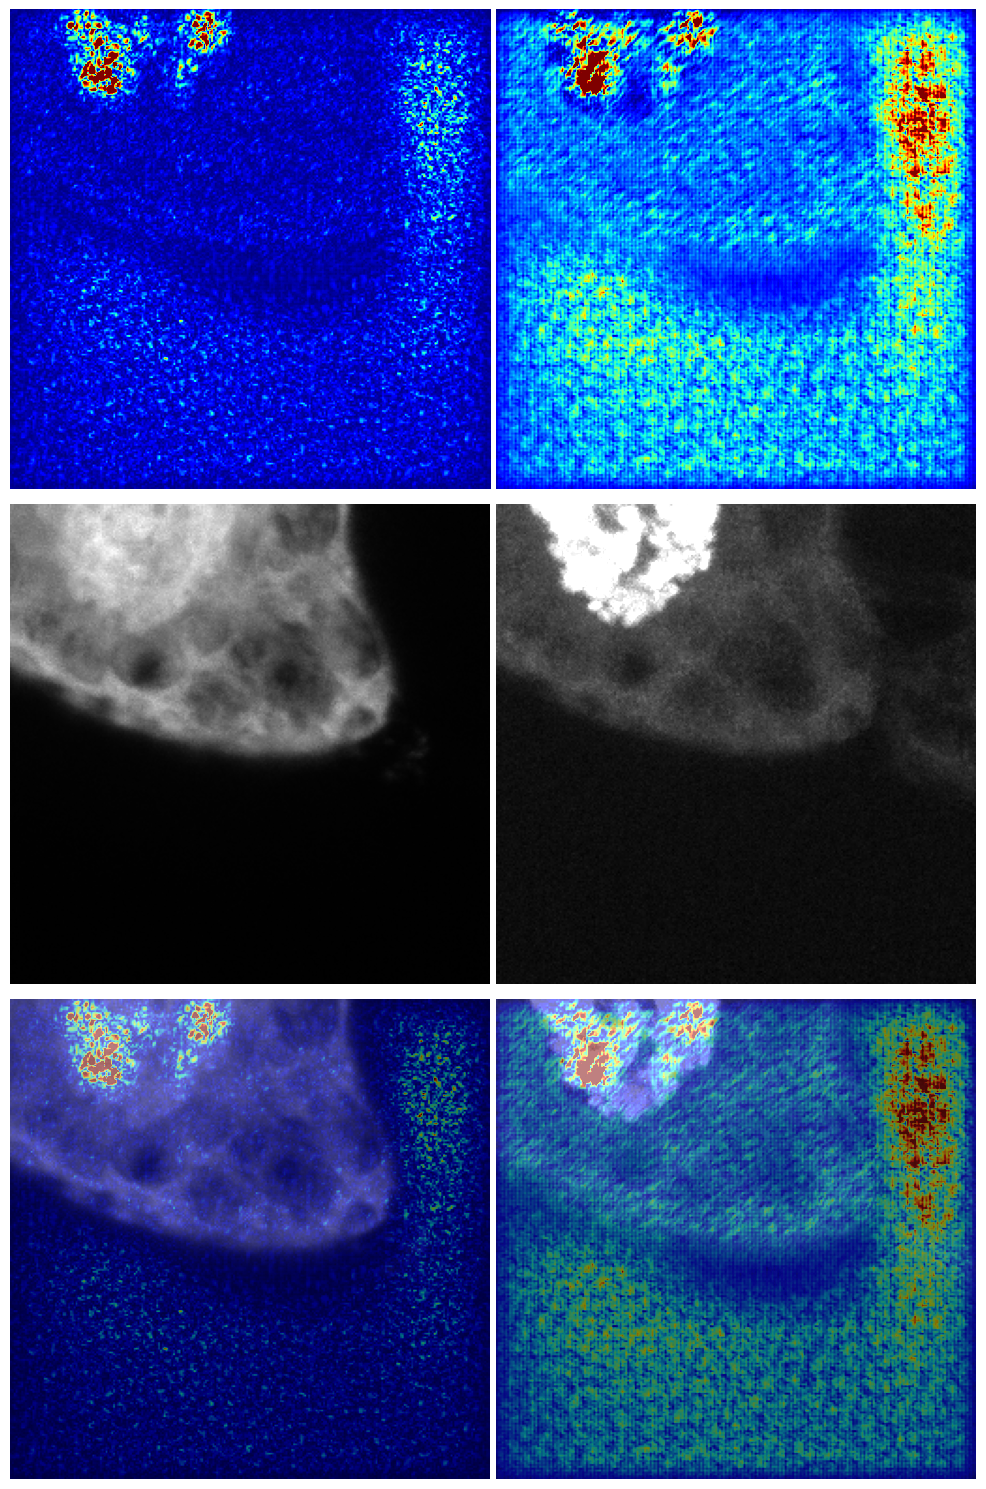

In [46]:
# Choose architecture
architecture = 'Unetplusplus' #'DeepLabV3plus' #'Segformer'
encoder = "resnet34"
batch_size = 1


# Create test dataset and dataloader
test_dataset = SpotDataset(
    image_dir='../../../data/patch_256/test/images',
    mask_dir='../../../data/patch_256/test/masks',
    transform=None,
)

test_no_spots = SpotDatasetNoSpots(
    image_dir='../../../data/patch_256/test/images',
    mask_dir='../../../data/patch_256/test/masks',
    transform=None,
)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
no_spots_dataloader = DataLoader(test_no_spots, batch_size=batch_size, shuffle=False, num_workers=4)
# Test finetuned model
preprocess_input = get_preprocessing_fn(encoder, pretrained='imagenet')
# best_model_path = f"lightning_logs/{architecture}/checkpoints/epoch=20-step=1071.ckpt"
# best_model_path = f"lightning_logs/{architecture}/checkpoints/epoch=20-step=546.ckpt"
best_model_path = f"lightning_logs/Unetplusplus_no_spots/checkpoints/epoch=35-step=936.ckpt"
model = SpotModel.load_from_checkpoint(
    best_model_path,
    arch=architecture,
    encoder_name=encoder,
    in_channels=3,
    out_classes=1
)


model = model.to('cuda')
model.eval()

img_indx = [180, 85]

for i, data in enumerate(no_spots_dataloader):
    if i == 180:
        img_id = data['img_id']
        image = data['image'].to('cuda')
        image = image.type(torch.float32)
        visualize_feature_maps(model.model, image, 'decoder.blocks.x_0_4.attention2')

        # Example usage
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        # ax.imshow(activation[0, i].cpu().numpy(), cmap='viridis')
        # ax.axis('off')

        target1 = 'encoder.layer2.0.conv1'
        grad_cam = GradCAM(model.model, target_layer=target1)
        cam1 = grad_cam.generate_cam(image, class_index=0, ind=i)

        target2='encoder.layer3.2.conv2'
        grad_cam = GradCAM(model.model, target_layer=target2)
        cam2 = grad_cam.generate_cam(image, class_index=0, ind=i)

        target3='decoder.blocks.x_0_4.attention2'
        grad_cam = GradCAM(model.model, target_layer=target3)
        cam3 = grad_cam.generate_cam(image, class_index=0, ind=i)
        
        ax[0].imshow(cam1, cmap='jet')
        ax[0].axis('off')
        ax[0].set_title(target1)

        ax[1].imshow(cam2, cmap='jet')
        ax[1].axis('off')
        ax[1].set_title(target2)

        ax[2].imshow(cam3, cmap='jet')
        ax[2].axis('off')
        ax[2].set_title(target3)


        
        plt.show()

        saliency_no_spot_channel(model.model, image,i)

    else:
        continue